## **Challenge Two: Build a Data Product**  


# Complaint Type Prediction - Traditional Machine Learning Algorithms with Class Imbalanced Data

Note: This notebook uses the **class imbalanced** data we formed from the NYC 311 Dataset in the notebook **Ezoic-Challenge-Two-Data-Preprocessing-1**

In [1]:
# Imports required
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
df_311 = pd.read_csv('nyc_311_imbalanced.csv', index_col=[0])

In [3]:
# making a copy of the df
df = df_311

In [4]:
df.head()

,complaint_type,text,labels
2,PLUMBING,shower stall,17
5,CONSTRUCTION,locks,1
6,PLUMBING,bathtub,17
7,PLUMBING,water leaks,17
14,OTHER,rubbish,16


In [5]:
# renaming the column
df.rename(columns={'labels': 'label'}, inplace=True)

In [6]:
df.head()

,complaint_type,text,label
2,PLUMBING,shower stall,17
5,CONSTRUCTION,locks,1
6,PLUMBING,bathtub,17
7,PLUMBING,water leaks,17
14,OTHER,rubbish,16


In [7]:
# creating a dict to map label to ids
category_id_df = df[['complaint_type', 'label']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['label', 'complaint_type']].values)

In [8]:
id_to_category

{0: 'AIR QUALITY',
 1: 'CONSTRUCTION',
 2: 'CONSTRUCTION SAFETY ENFORCEMENT',
 3: 'CONSUMER COMPLAINT',
 4: 'DCA / DOH NEW LICENSE APPLICATION REQUEST',
 5: 'DOF PARKING - PAYMENT ISSUE',
 6: 'DOF PROPERTY - PAYMENT ISSUE',
 7: 'DOF PROPERTY - REDUCTION ISSUE',
 8: 'ELECTRICAL',
 9: 'FOOD ESTABLISHMENT',
 10: 'HAZARDOUS MATERIALS',
 11: 'HIGHWAY CONDITION',
 12: 'HPD LITERATURE REQUEST',
 13: 'ILLEGAL PARKING',
 14: 'MAINTENANCE OR FACILITY',
 15: 'NOISE',
 16: 'OTHER',
 17: 'PLUMBING',
 18: 'SANITATION',
 19: 'SCRIE',
 20: 'SEWER',
 21: 'STREET CONDITION',
 22: 'TRAFFIC',
 23: 'TREE',
 24: 'VIOLATION OF PARK RULES',
 25: 'WATER CONSERVATION'}

In [10]:
# total label count. Adding 1 for 0 index
label_count = df['label'].nunique() + 1

In [11]:
X = df['text'] # samples
y = df['complaint_type'] # targets

# Splitting data for train-test

In [12]:
# train-test split with sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Vectorization of the text data using TFIDF

In [13]:
# TFIDF Vectorizer converts a collection of raw text to a matrix of TF-IDF features.
"""
min_df : When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
"""
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df.text).toarray()
labels = df.label

# Models chosen for Cross Validation:
*   Logistic Regression (One vs Rest Approach)
*   Random Forest Algorithm
*   Linear Support Vector Classifier (Linear SVC)
*   Multinomial NB (Multinomial Naive Bayes)



In [14]:
from sklearn.utils import multiclass
models = [
    LogisticRegression(random_state = 42, multi_class = 'ovr'),
    RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth=5, random_state = 42),
    LinearSVC(),
    MultinomialNB() 
]

# K-Fold Cross Validation

Cross-validation is a statistical method used to estimate the skill of machine learning models.  

The k-fold cross-validation procedure divides a limited dataset into k non-overlapping folds.  
Each of the k folds is given an opportunity to be used as a held-back test set, whilst all other folds collectively are used as a training dataset.  
A total of k models are fit and evaluated on the k hold-out test sets and the mean performance is reported.

In [15]:
# Defining K valie with CV variable
CV = 10

# Creating a df for cv
cv_df = pd.DataFrame(index = range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [16]:
# Sample entries in the cv_df dataframe
cv_df.sample(n=5)

,model_name,fold_idx,accuracy
12,RandomForestClassifier,2,0.384615
21,LinearSVC,1,0.604396
36,MultinomialNB,6,0.488889
17,RandomForestClassifier,7,0.377778
8,LogisticRegression,8,0.544444


Plotting model performance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


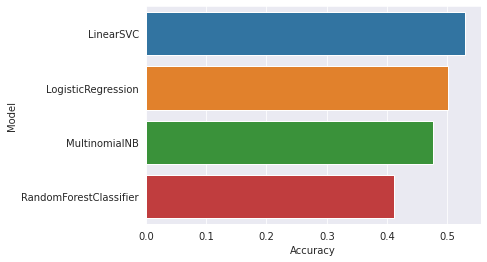

In [17]:
# Plotting the mean accuracy of all the models by grouping on model name
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
sns.barplot(mean_accuracy.values, mean_accuracy.index)
plt.ylabel('Model')
plt.xlabel('Accuracy')
accuracies = pd.concat([mean_accuracy], axis= 1, 
          ignore_index=True)
accuracies.columns = ['Mean Accuracy']

In [18]:
accuracies

,Mean Accuracy
model_name,
LinearSVC,0.528596
LogisticRegression,0.501062
MultinomialNB,0.475678
RandomForestClassifier,0.411661


From the above table and bar-plot, it is evident that the **Linear SVC** model has achieved the best accuracy of **52.8%**.  

Just after Linear SVC comes **Logistic Regression** with **50% **accuracy.

# Model Training

Since Linear SVC has performed the best in Cross Validation, we go ahead with it and train.

In [19]:
# Model eval
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
                                                               features, 
                                                               labels, 
                                                               df.index, 
                                                               test_size=0.2, 
                                                               random_state=42)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Classification Metrics

The heatmap plotted below shows the **Precison**, **Recall** and **F1-Score** of the Linear SVC Model on all the classes.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2094: UserWarning: labels size, 906, does not match size of target_names, 26
  len(labels), len(target_names)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

[Text(0.5, 0, 'precision'), Text(1.5, 0, 'recall'), Text(2.5, 0, 'f1-score')]

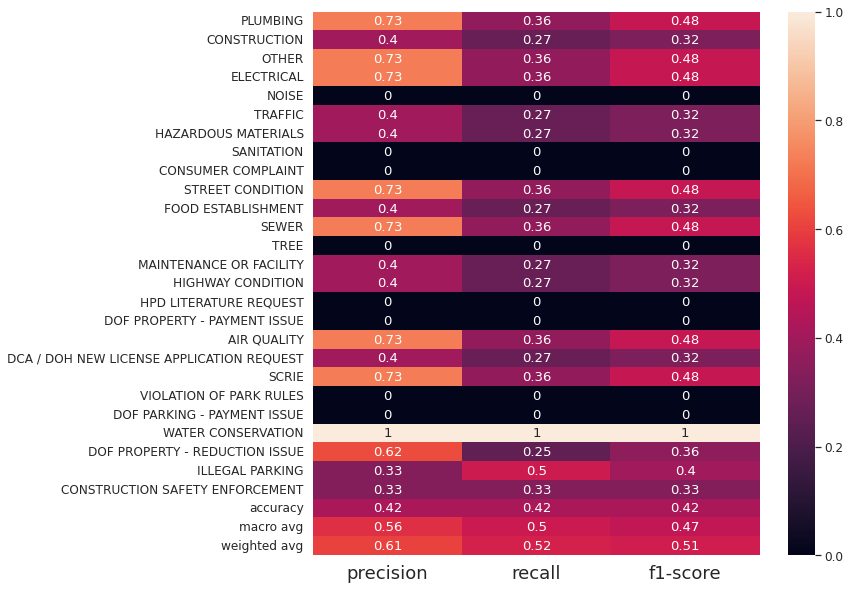

In [20]:
clf_report = metrics.classification_report(y_test,
                                   y_pred,
                                   labels=labels,
                                   target_names=df['complaint_type'].unique(),
                                   output_dict=True)
plt.figure(figsize=(10,10))
sns.set(font_scale = 1.1)
res = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), size = 18)

I have written below about my understanding of the above given metrics:

1) Accuracy: It is the ratio of the number of correct predictions to the total number of predictions our model has done.

2) Precision: Talks about how precise/accurate our model is. Out of the positive predictions, how many are actually positive ?

3) Recall: What proportion of actual positives was identified correctly?

The Confusion Matrix for the Linear SVC Model

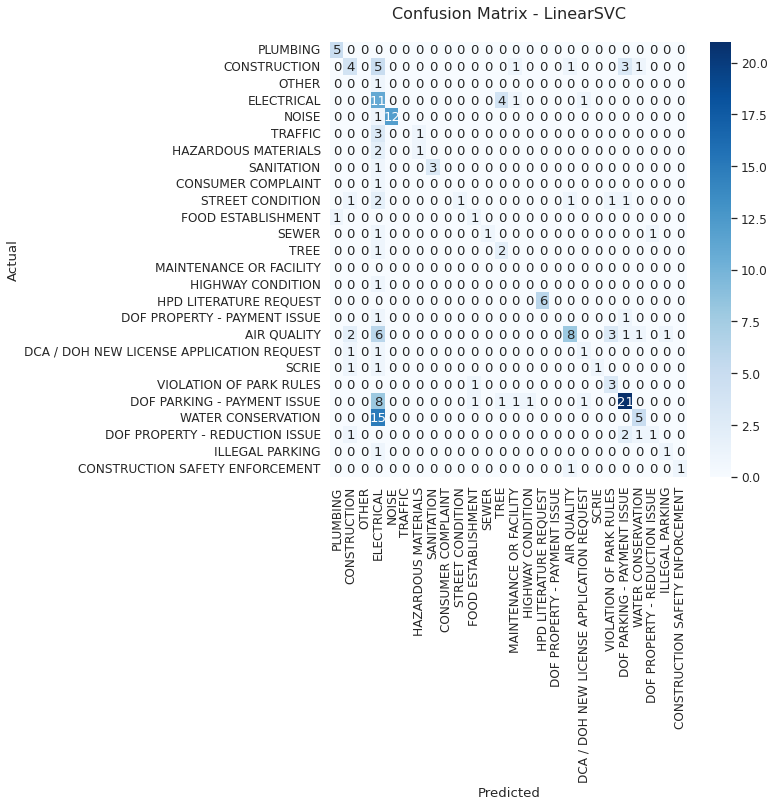

In [21]:
# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.complaint_type.values, 
            yticklabels=category_id_df.complaint_type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - LinearSVC\n", size=16);

# Model Testing on Unseen Data

In [22]:
# Prediction on Unseen Data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state = 42)

tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5, ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [23]:
new_complaint = "zebra crossing faded"
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['CONSUMER COMPLAINT']


In [27]:
new_complaint = "Loud music in this area"
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['CONSUMER COMPLAINT']


In [28]:
new_complaint = "bad street needs cleaning"
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['STREET CONDITION']


In [26]:
new_complaint = "water pipe has broken"
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['PLUMBING']
